# Pràctica 4: SVM

## Gerard Santacatalina Rubio - 1534002 

## Avaluació i entregues

### Entregues
Les pràctiques es realitzarán els divendres de 15:00 a 17:00. Cada setmana presentarem nous mètodes i algorismes vistos a la classe de teoria.

L'entrega, es realitzarà el següent dijous abans de les 23:59, és a dir, tindreu les hores de classe més tota una setmana per a realitzar les tasques. Es pujará un .ipynb ja executat, on no només hi hagi codi sinó també text explicatiu de gràfiques, resultats, i analisis. Tingueu en compte que no es valora tant la quantitat, sino la qualitat del que s'hi explica. Hem d'aprendre a extreure el gra de la palla i presentar-ho de forma correcta i concisa.


### Avaluació
Aquesta práctica será molt més dirigida que l'anterior. S'evaluarán els següents conceptes sobre una mateixa base de dades, que tractarà sobre els vins:

* A. SVM (20%)
* B. ROC curve vs PR (30%)
* C. Crossvalidation (30%)
* D. Hyperparameter search (20%)


### Dataset
Per aquesta pràctica hem decidit treballar amb una base de dades de imatges. Es tracta de [Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist). És similar a la base de dades de MNIST, un dataset clàssic en la visió per computador. Són imatges de 28x28 pixels i en escala de grisos. El original disposa de 60.000 imatges de entrenament i 10.000 de test. Està anotat en 10 categories diferents:

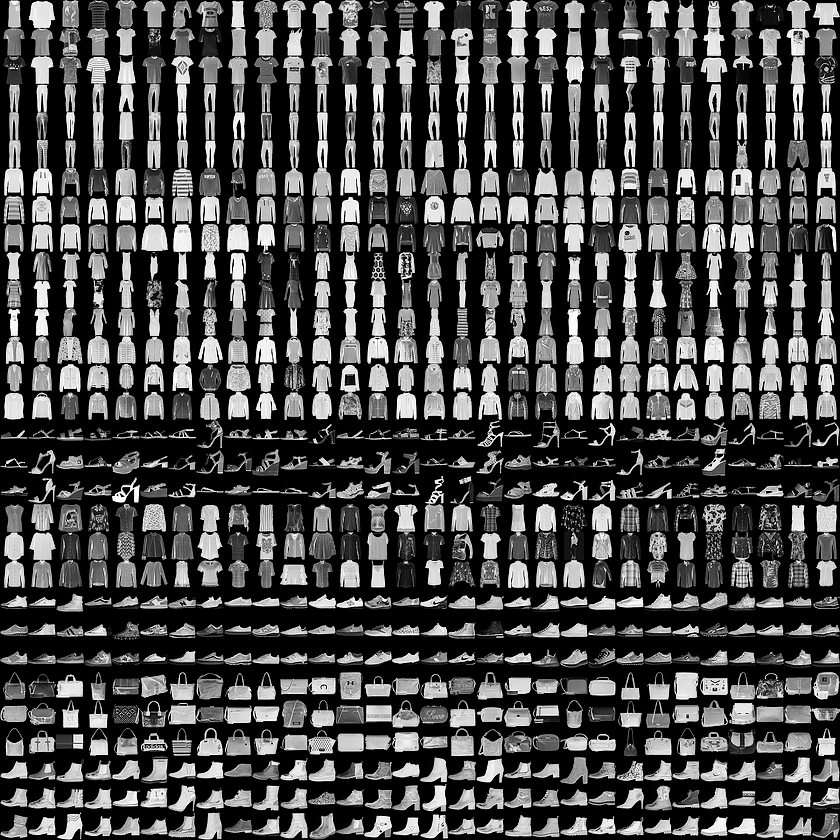

|Id|Nom|
|:-:|:--|
|0|T-shirt/top 
|1|Trouser |
|2|Pullover| 
|3|Dress|
|4|Coat|
|5|Sandal|
|6|Shirt|
|7|Sneaker|
|8|Bag |
|9|Ankle boot|


Ens hem descarregat el csv desde: https://www.kaggle.com/zalando-research/fashionmnist.

Els hem simplificat i dividit en altres csv més petits. Tenim els originals, i llavors un subsampling (100 vegades més petit). Dels petits, a més, també tenim el cas binari.

| nom | set | # exemples | # categories |
|:--|:-:|:-:|:-:|
|fashion-mnist_train_small_binary.csv   |train|     600 |  2 |
|fashion-mnist_test_small_binary.csv    |test |     100 |  2 |
|fashion-mnist_train_small.csv          |train|     600 | 10 |
|fashion-mnist_test_small.csv           |test |     100 | 10 |
|fashion-mnist_train.csv                |train|  60.000 | 10 |
|fashion-mnist_test.csv                 |test |  10.000 | 10 |

Les dues originals, les podeu *descarregar* del link de [Kaggle](https://www.kaggle.com/zalando-research/fashionmnist?select=fashion-mnist_train.csv). Son uns 150MB una vegada descomprimits.


In [1]:
# Importar llibreries i obrir el dataset

import numpy as np
import pandas as pd
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
# sns.set_theme()

# Visualitzarem només 3 decimals per mostra, i definim el num de files i columnes a mostrar
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 50)

# Funcio per a llegir dades en format csv
def load_dataset(path, shuffle=False):
    dataset = pd.read_csv(path, header=0, delimiter=',')
    if shuffle:
        dataset = dataset.sample(frac=1).reset_index(drop=True)
    return dataset

# Carreguem dataset d'exemple
dataset = load_dataset('fashion-mnist_train_medium.csv')
y_train = dataset["label"]
X_train = dataset.drop("label", axis="columns")


print("Dimensionalitat de la BBDD:", dataset.shape)


FileNotFoundError: [Errno 2] No such file or directory: 'fashion-mnist_train_medium.csv'

In [2]:
dataset = load_dataset('fashion-mnist_train.csv')
dataset = dataset[:6000]
dataset.to_csv('fashion-mnist_train_medium.csv', index=False)

## A. SVM (20%)

L'objectiu d'aquest apartat es familiaritzar-se amb el modul de [SVM de sklearn](https://scikit-learn.org/stable/modules/svm.html).

En aquest apartat només farem servir les dades **fashion-mnist_train_small_binary.csv**	i **fashion-mnist_train_small.csv**



Bàsicament tenim a dos models: el [SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) i el [LinearSVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html)

#### SVC

El model SVC está implementat a través de libsvm. El temps d'entrenament escala almenys **quadràticament** amb el número de exemples.

A més, el multiclass s'implementa amb la estratègia One-Vs-One (OVO).

Tot i així, ens permet fer servir varis **kernels**: 
* ‘linear’
* ‘poly’ 
* ‘rbf’ (default)
* ‘sigmoid’ 
* ‘precomputed’ 

Mireu quins parametres apliquen a cada un dels kernels a la seva [documentació](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html).

*EL FAREM SERVIR QUAN TENIM **POCS EXEMPLES**, O MOLT DE TEMPS..*

#### LinearSVC

El model SVC está implementat a través de liblinear. Hauria de permetre treballar amb més dades (escala molt millor amb el número d'exemples).

A més, el multiclass s'implementa amb la estratègia One-Vs-Rest (OVR)

*EL FAREM SERVIR QUAN TENIM **MOLTS EXEMPLES** i el temps de SVC es intractable*




Recordeu el que significa One-Vs-One (OVO) i One-Vs-Rest (OVR)

![OvA_OvO.png](ch06_fig_8_mlr.png)


És importnat avaluar les diferents alternatives disponibles per resoldre els problemes que abordem: [comparativa](https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html)

Exemple de SVC:

In [4]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC, LinearSVC

clf = make_pipeline(StandardScaler(), LinearSVC(max_iter=10000))
clf.fit(X_train, y_train)

C:\Users\usuario\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc', LinearSVC(max_iter=10000))])

In [72]:
y_train_pred = clf.predict(X_train)
y_train_scr = clf.decision_function(X_train)

accuracy_train = accuracy_score(y_train, y_train_pred)

print(f"The accuracy on training is {accuracy_train:.5f}")
np.set_printoptions(linewidth=np.inf)
print(np.c_[y_train_scr[:10,:],y_train_pred[:10]])

The accuracy on training is 0.98383
[[ -1.50434831  -1.783365     0.83484286  -4.1364314   -5.85532926  -6.79823589  -3.16827037 -13.55939023  -2.42477268  -3.82790643   2.        ]
 [ -8.89985515  -1.95412782  -4.63231723  -3.87152936  -9.56825105  -2.24749328  -6.92508931  -0.90889722  -1.05451474   0.89839457   9.        ]
 [ -7.65804957  -2.97838636  -4.30035337  -5.50281183  -0.75864716  -5.60254818   1.17902574  -9.58966274  -2.10148097  -3.43388403   6.        ]
 [  6.79583036  -2.78091903  -0.89552266  -5.45105136  -3.21332171 -10.86771393  -6.14761448  -3.01259629  -1.01073907  -1.62678197   0.        ]
 [ -5.62591015  -4.16871916  -4.23202879   4.2407329   -4.18150199  -6.36724624  -1.81372521  -4.83386912  -4.28461704  -5.71436571   3.        ]
 [ -9.8519373   -3.80434893  -2.44862273 -12.25199468   0.97290205  -3.89686243  -0.19227044  -5.83015234  -2.02702766  -3.35596322   4.        ]
 [ -5.76216052  -3.02582159  -3.15251748  -3.82945789   3.28908708  -7.3039479   -4.0693

### Preguntes

#### binary classification
1. Entrena un model SVC **binary** (nomès dues categories) amb les dades **fashion-mnist_train_small_binary.csv**. Comprova el error de predicció sobre el conjunt d'entrenament. 
2. Quin model has fet servir per defecte? Amb quina C? Podries millorar el error de entrenament fàcilment (imagina que nomès tens 2 intents). Què modificaries)?
3. Explica què son els atributs clf.support_vectors_ i el clf.n_support_
4. Entrena un model LinearSVC sobre les mateixes dades. Quin accuracy de train obtens? És més ràpid? 
5. Saps on han anat els atributs clf.support_vectors_ i el clf.n_support_ en el cas del LinearSVC? Tenen alguna relació amb el clf.coef_ i clf.intercept_? [Pista](https://scikit-learn.org/stable/auto_examples/svm/plot_linearsvc_support_vectors.html)

#### multiclass classification
6. Entrena un model SVC multicategoria amb les dades **fashion-mnist_train_small.csv**
7. Entrena un model LinearSVC multicategoria. Quin accuracy de train obtens?

#### selecció de mètode
8. Compara els resultats obtinguts amb els altres mètodes de classificació que coneixes

### Binary classification

#### Pregunta 1: Entrena un model SVC binary (només dues categories) amb les dades fashion-mnist_train_small_binary.csv. Comprova el error de predicció sobre el conjunt d'entrenament.

Veiem tot seguit que el error de predicció és d'un 3,3%. El accuracy sobre el train és del 96,7%.

In [7]:
mnist_smmallb_train = load_dataset('fashion-mnist_train_small_binary.csv')
mnist_smmallb_train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,...,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,5,0,0,0,105,92,101,107,100,132,0,0,2,4,0,1,0,...,0,0,44,12,0,0,40,134,162,191,214,163,146,165,79,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,0,114,183,112,55,23,72,102,165,160,28,0,0,0,1,...,0,0,0,1,0,0,0,22,21,25,69,52,45,74,39,3,0,0,0,0,1,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0,0,46,0,21,68,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,68,116,112,136,147,144,121,102,63,0,0,0,0,0,0,0,0,0,0


In [8]:
mnist_smmallb_test = load_dataset('fashion-mnist_test_small_binary.csv')
mnist_smmallb_test.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,...,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,9,8,0,0,34,29,7,0,11,24,0,0,3,3,1,0,1,...,0,0,0,0,37,69,94,123,127,138,138,142,145,135,125,103,87,56,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,209,190,181,150,170,193,180,219,5,0,0,0,0,...,0,0,0,0,0,0,0,0,174,233,155,0,65,235,216,34,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,14,53,99,17,0,0,0,0,0,0,0,0,12,94,68,14,0,0,...,0,46,50,29,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,63,53,31,0,0,0
3,1,0,0,0,0,0,0,0,0,0,161,212,138,150,169,164,176,202,255,183,26,0,0,0,0,...,168,232,225,0,41,172,147,148,153,155,146,137,141,143,137,137,126,140,0,133,224,222,56,0,0
4,1,0,0,0,0,0,0,0,0,0,0,37,0,0,0,0,0,0,17,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,2,69,0,2,0,0,0,0,0,0,0,0,0,0


In [9]:
from sklearn.model_selection import train_test_split
import time
from sklearn.metrics import accuracy_score
llista_prediccions_binari = []

inici = time.time()


model_smallb = SVC()
y_smallb_train = mnist_smmallb_train["label"]
x_smallb_train = mnist_smmallb_train.drop("label", axis=1)
y_smallb_test = mnist_smmallb_test["label"]
x_smallb_test = mnist_smmallb_test.drop("label", axis=1)
model_smallb.fit(x_smallb_train, y_smallb_train)
y_score_binary_svc = model_smallb.decision_function(x_smallb_train)
y_train_pred = model_smallb.predict(x_smallb_train)
y_test_pred = model_smallb.predict(x_smallb_test)
llista_prediccions_binari.append(y_test_pred)
accuracy = accuracy_score(y_smallb_train, y_train_pred)
print("Tenim un accuracy sobre el training de: "+str(round(accuracy,3)))
print("El error de predicció pel training serà doncs de: "+str(round(1-accuracy,3)))
print("El que ha trigat en executar-se han estat: "+str(round(time.time()-inici,3))+" segons.")

Tenim un accuracy sobre el training de: 0.968
El error de predicció pel training serà doncs de: 0.032
El que ha trigat en executar-se han estat: 0.073 segons.


#### Pregunta 2: Quin model has fet servir per defecte? Amb quina C? Podries millorar el error d'entrenament fàcilment (pensem que només tenim dos intents). Què modificaries?

Com tenim poques dades en aquest dataset he decidit treballar amb el SVC. La C amb la que s'ha executat era la que ens fica el modul sklearn per default (C=1.0), no l'he canviat.

Al modificar el paràmetre del degree del polinomi sembla no canviar gaire però quan canvio el paràmetre C si que puja disminueix bastant el error, o això és el que em sembla...

El que faria seria molt probablement canviar el paràmetre C que ens explica com serà la regularització que estarem fent servir i després també miraria de canviar el function_shape per fer un one versus one perquè sembla donar millors resultats i a més a més baixaria la tolerancia encara més, ficaria un valor més petit perquè aquesta tolerància sigui encara més exigent a l'hora de continuar amb les iteracions. 
Així i tot he provat els dos darrers canvis sense canviar la C de default i surt el mateix que a abans, no hi ha gaire canvi pel que fa a l'error així es que no se si realment tenen un impacte gaire significatiu, suposo que no... 
No obstant si augmento la C el que passa es que cada cop es fa una regularització més i més gran però diria que això tampoc és el que volem perquè ens porta a casos de overfitting... 


In [10]:

model_smallb = SVC(C=2,decision_function_shape="ovo", tol=1e-7)
model_smallb.fit(x_smallb_train, y_smallb_train)
y_train_pred = model_smallb.predict(x_smallb_train)
accuracy = accuracy_score(y_smallb_train, y_train_pred)
print("Tenim un accuracy sobre el training de: "+str(round(accuracy,3)))
print("El error de predicció pel training serà doncs de: "+str(round(1-accuracy,3)))

Tenim un accuracy sobre el training de: 0.982
El error de predicció pel training serà doncs de: 0.018


#### Pregunta 3: Explica que són els atributs clf.support_vectors_ i clf.n_support_
Tots dos són atributs que ens defineixen els vectors de suport amb els que es basa el nostre model (SVC i LinearSVC) que no és més que un subconjunt de les dades de training. Pel que fa a l'atribut clf.support_vectors_ el que ens diu és bàsicament els vectors de suport com a tal mentre que el segon (clf.n_support_) ens diu el nombre de vectors de suport per cada classe. 

In [11]:
model_smallb.support_vectors_

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [12]:
model_smallb.n_support_

array([43, 68])

#### Pregunta 4: Entrena un model LinearSVC sobre les mateixes dades. Quin accuracy de train obtens? És més ràpid?
El primer que veig és que al executar-ho em surt un warning com que no s'ha arribat a la convergència i em demana incrementar el nombre d'iteracions. Sabem que aquest nombre d'iteracions per default és 1000.
Si provem amb 1800 iteracions aleshores sembla que arriba a la convergència i obtenim un accuracy sobre el training del 100% (1.0) i un error del 0%, clarament suposa una millora respecte al darrer. Em sembla massa alt, he buscat informació per veure si això és un error meu o pot ser que em doni uns valors tant alts però pel que sembla no hi ha res que hagi fet malament pel que he estat veient. 
Respecte al temps no ha millorat, el temps no canvia gaire però passem de tenir 0.10 segons a tenir.ne 0.11. No hi ha una diferència significativa però no és més ràpid. 

In [13]:
import time 

inici = time.time()
model_smallb = LinearSVC(max_iter=1800)
model_smallb.fit(x_smallb_train, y_smallb_train)
y_score_binary_lsvc = model_smallb.decision_function(x_smallb_train)
y_train_pred = model_smallb.predict(x_smallb_train)
y_test_pred = model_smallb.predict(x_smallb_test)
llista_prediccions_binari.append(y_test_pred)
accuracy = accuracy_score(y_smallb_train, y_train_pred)
print("Tenim un accuracy sobre el training de: "+str(round(accuracy,3)))
print("El error de predicció pel training serà doncs de: "+str(round(1- accuracy,3)))

temps_total = round(time.time() - inici, 3)

print("El temps que ha trigat en executar-se és de: "+str(temps_total)+" segons")

Tenim un accuracy sobre el training de: 1.0
El error de predicció pel training serà doncs de: 0.0
El temps que ha trigat en executar-se és de: 0.075 segons


#### Pregunta 5: Saps on han anat els atributs clf.support_vectors_ i el clf.n_support_ en aquest cas (LinearSVC)? Tenen alguna relació amb els atributs clf.coef_ i clf.intercept_? 

Conceptualment tant SVC com LinearSVC són bastant similars però tenen algunes diferències en la seva implementació que fa que bàsicament en el cas del LinearSVC els atributs que hem vist com són el clf.support_vectors i el clf.n_support_ no existeixin perquè es tracta d'un classificador lineal i aleshores per ser un classificador lineal els atributs que el defineixen a aquest és el intercepte i els coeficients de la recta. Pel cas del SVC tenim kernels per provar i podem adaptar bastant la implementació segons el tipus de problema amb el que estem tractant, ens dona més llibertat per poder fer servir alguna mena de classificador no lineal concret i en aquest cas els atributs que defineixen un classificador no lineal són els vectors de suport i el nombre de vectors de suport per classe. Bàsicament són dos conceptes diferents. 


### Multiclass classification 

#### Pregunta 6: Entrena un model SVC multicategoria amb les dades fashion-mnist_train_small.csv
Primer que tot carregarem el dataset en qüestió i aplicarem un SVC mirant el accuracy que té sobre el training set i el error que obtenim sobre aquest mateix. Com veiem per aquest cas multicategoria el accuracy baixa i el error puja amb l'augment de la complexitat del problema.

In [14]:
mnist_smmall_train = load_dataset('fashion-mnist_train_small.csv')
mnist_smmall_train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,...,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,0,0,105,92,101,107,100,132,0,0,2,4,0,1,0,...,0,0,44,12,0,0,40,134,162,191,214,163,146,165,79,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,0,114,183,112,55,23,72,102,165,160,28,0,0,0,1,...,0,0,0,1,0,0,0,22,21,25,69,52,45,74,39,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,0,0,0,46,0,21,68,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,68,116,112,136,147,144,121,102,63,0,0,0,0,0,0,0,0,0,0


In [15]:
mnist_smmall_test = load_dataset('fashion-mnist_test_small.csv')
mnist_smmall_test.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,...,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,9,8,0,0,34,29,7,0,11,24,0,0,3,3,1,0,1,...,0,0,0,0,37,69,94,123,127,138,138,142,145,135,125,103,87,56,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,209,190,181,150,170,193,180,219,5,0,0,0,0,...,0,0,0,0,0,0,0,0,174,233,155,0,65,235,216,34,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,14,53,99,17,0,0,0,0,0,0,0,0,12,94,68,14,0,0,...,0,46,50,29,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,63,53,31,0,0,0
3,2,0,0,0,0,0,0,0,0,0,161,212,138,150,169,164,176,202,255,183,26,0,0,0,0,...,168,232,225,0,41,172,147,148,153,155,146,137,141,143,137,137,126,140,0,133,224,222,56,0,0
4,3,0,0,0,0,0,0,0,0,0,0,37,0,0,0,0,0,0,17,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,2,69,0,2,0,0,0,0,0,0,0,0,0,0


In [16]:
llista_prediccions_multiclass = []
model_small = SVC()
y_small_train = mnist_smmall_train["label"]
x_small_train = mnist_smmall_train.drop("label", axis=1)
y_small_test = mnist_smmall_test["label"]
x_small_test = mnist_smmall_test.drop("label", axis=1)
model_small.fit(x_small_train, y_small_train)
y_score_multiclass_svc = model_small.decision_function(x_small_train)
y_train_pred = model_small.predict(x_small_train)
y_test_pred = model_small.predict(x_small_test)
llista_prediccions_multiclass.append(y_test_pred)
accuracy = accuracy_score(y_small_train, y_train_pred)
print("Tenim un accuracy sobre el training de: "+str(round(accuracy,3)))
print("El error de predicció pel training serà doncs de: "+str(round(1- accuracy,3)))

Tenim un accuracy sobre el training de: 0.868
El error de predicció pel training serà doncs de: 0.132


#### Pregunta 7: Entrena un model LinearSVC multicategoria. Quin accuracy de train obtens?
El accuracy que obtenim amb el LinearSVC multicategoria segueix sent el mateix que abans pel cas binari, tenim un sorpresiu 100% de accuracy. Un error del 0%. 

In [17]:
model_small = LinearSVC(max_iter=4000)
model_small.fit(x_small_train, y_small_train)
y_score_multiclass_lsvc = model_small.decision_function(x_small_train)
y_train_pred = model_small.predict(x_small_train)
y_test_pred = model_small.predict(x_small_test)
llista_prediccions_multiclass.append(y_test_pred)
accuracy = accuracy_score(y_small_train, y_train_pred)
print("Tenim un accuracy sobre el training de: "+str(round(accuracy,3)))
print("El error de predicció pel training serà doncs de: "+str(round(1- accuracy,3)))

Tenim un accuracy sobre el training de: 1.0
El error de predicció pel training serà doncs de: 0.0


### Selecció de mètode 

#### Pregunta 8: Compara els resultats obtinguts amb els altres mètodes de classificació que coneixes
Aquí els mètodes de classificació que faré servir serà un KNN i un LogisticRegressor per exemple. 
Començem pel KNN, primer provarem amb el dataset small multicategoria en el que veiem que tenim un accuracy d'un 81,2% amb un error d'un 19% aprox. 

In [28]:
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier()
knn_model.fit(x_small_train, y_small_train)
y_scores_multiclass_knn = knn_model.predict_proba(x_small_test)
y_train_pred = knn_model.predict(x_small_train)
accuracy = accuracy_score(y_small_train, y_train_pred)
print("Tenim un accuracy sobre el training de: "+str(round(accuracy,3))+" amb un KNN.")
print("El error de predicció pel training serà doncs de: "+str(round(1- accuracy,3)))

Tenim un accuracy sobre el training de: 0.802 amb un KNN.
El error de predicció pel training serà doncs de: 0.198


Tot seguit aplicant el mateix algorisme del KNN provarem amb el dataset petit però aquest cop pel cas en el que tenim només dues categories. Aquí al reduïr la complexitat del problema veiem com augmenta el accuracy i disminueix el error al fer la classificació amb un nombre més petit de categories, arribant fins a un 96% de accuracy.

In [29]:
knn_model = KNeighborsClassifier()
knn_model.fit(x_smallb_train, y_smallb_train)
y_train_pred = knn_model.predict(x_smallb_train)
accuracy = accuracy_score(y_smallb_train, y_train_pred)
print("Tenim un accuracy sobre el training de: "+str(round(accuracy,3))+" amb un KNN.")
print("El error de predicció pel training serà doncs de: "+str(round(1- accuracy,3)))

Tenim un accuracy sobre el training de: 0.963 amb un KNN.
El error de predicció pel training serà doncs de: 0.037


Tot seguit passem amb una classificador logistic que vam veure a la darrera pràctica fent servir un descens estocastic del gradient (SGD) que vam veure que ens donava resultats bastant bons. Pel cas multicategoria ens dona un accuracy bastant bo, d'un 98% amb un error d'un 2%. (sobre el train).

In [30]:
from sklearn.linear_model import SGDClassifier

sgd_log_classifier = SGDClassifier()
sgd_log_classifier.fit(x_small_train, y_small_train)
y_score_multiclass_sgdc = sgd_log_classifier.decision_function(x_small_train)
y_train_pred = sgd_log_classifier.predict(x_small_train)
accuracy = accuracy_score(y_small_train, y_train_pred)
print("Tenim un accuracy sobre el training de: "+str(round(accuracy,3))+" amb un SGDClassifier.")
print("El error de predicció pel training serà doncs de: "+str(round(1- accuracy,3)))


Tenim un accuracy sobre el training de: 0.972 amb un SGDClassifier.
El error de predicció pel training serà doncs de: 0.028


Si reduïm la complexitat del problema i fem servir el mateix algorisme amb només dues categories veiem que el accuracy és perfecte amb un error nul.

In [31]:

sgd_log_classifier.fit(x_smallb_train, y_smallb_train)
y_train_pred = sgd_log_classifier.predict(x_smallb_train)
accuracy = accuracy_score(y_smallb_train, y_train_pred)
print("Tenim un accuracy sobre el training de: "+str(round(accuracy,3))+" amb un SGDClassifier.")
print("El error de predicció pel training serà doncs de: "+str(round(1- accuracy,3)))


Tenim un accuracy sobre el training de: 1.0 amb un SGDClassifier.
El error de predicció pel training serà doncs de: 0.0


Veiem doncs que amb un LinearSVC obtenim uns resultats perfectes tant pel cas multicategoria com pel que només tenim dues categories, no he fet tampoc un gran testing però a simple vista sembla que el LinearSVC ens dona millors resultats que el SGDClassifier de la pràctica passada. Ara resta provar-ho tot això a datasets una mica més exigents i entusiastes, el dataset amb el que s'han fet aquestes proves és força petit. 

### B. ROC curve vs PR  (30%)

Un cop apresos els models de svm, com afecten els seus parametres i els kernels, veurem com evaluar-ho correctament.

Per fer això, farem ús de la matriu de confusió per veure si estem classificant correctament [sklearn.metrics.confusion_matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html)


Text(0.5, 47.629090909090905, 'true label')

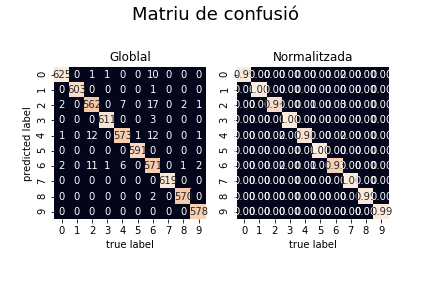

In [75]:
import ipympl
%matplotlib widget 
from sklearn.metrics import confusion_matrix

mat = confusion_matrix(y_train, y_train_pred)
f,axs=plt.subplots(1,2)
f.suptitle('Matriu de confusió', fontsize=18)
axs[0].set_title('Globlal', fontsize=12)
axs[1].set_title('Normalitzada', fontsize=12)
sns.heatmap(mat.T, ax=axs[0], square=True, annot=True, fmt='d', cbar=False)
axs[0].set_xlabel('true label')
axs[0].set_ylabel('predicted label');
mat = confusion_matrix(y_train, y_train_pred, normalize='true')
sns.heatmap(mat.T, ax=axs[1], square=True, annot=True, fmt='.2f', cbar=False)
axs[1].set_xlabel('true label')


A través de la matriu de confusió es pot calcular fàcilment el accuracy, el f1-score, la precisió, el recall... Totes aquestes són mètriques que el calculen com de bé o malament ho fa un classificador tenint en compte **un llindar especific** (i.e. 0.5), o en el cas multiclasse també pot ser la classe més probable. Ara bé, si volguessim visualtizar com de bé ho fa cada classificador per **qualsevol valor del llindar**, podem veure el seu comportament a través de analitzar la [curva ROC](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html) i la [curva Precision-Recall](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.average_precision_score.html). Per a utilitzar-lo, necesiteu extreure un score de confiança o unes probabilitats de classificació per a cada una de les categories. Ho podem trobar utilitzant la funció:

* clf.decision_function(X) [per SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC.decision_function) i [per LinearSVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC.decision_function)

Recordem com es calcula la curva ROC i la Precision-Recall. Per cada valor del llindar, tindrem una matriu de confusió diferent. La ROC mostra el **TPR** vs **FPR** i la PR mostra la relació entre **Precision** vs **Recall**.

True Positive Rate (TPR): del total d'exemples positius, quants hem classificat com a positiu.

$$TPR = Recall = Sensitivity = \frac{TP}{TP + FN}$$

False Positive Rate (FPR): del total d'exemples negatius, quantes falses alarmes positives apareixen.

$$FPR = 1 - Specificity = \frac{FP}{FP + TN}$$

Precision: Quina proporcio de prediccions positives es correcta.

$$Precision = \frac{TP}{TP + FP}$$

<img src="https://miro.medium.com/max/1340/1*urQ3A6h1BNgGM__Uvkwviw.png" width=600>

Si voleu refrescar o aprendre més coses sobre aquestes curves, us recomano aquest [blog](https://towardsdatascience.com/on-roc-and-precision-recall-curves-c23e9b63820c)

Exemple:

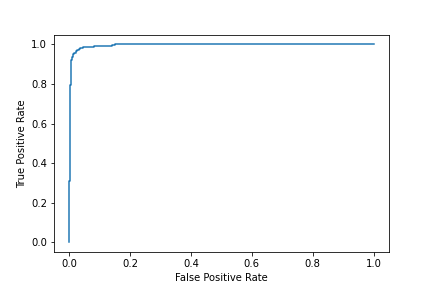

In [79]:
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
y_score = clf.decision_function(X_train)
lab = 2
fpr, tpr, thr = roc_curve(y_train, y_score[:,lab], pos_label=clf.classes_[lab])
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()


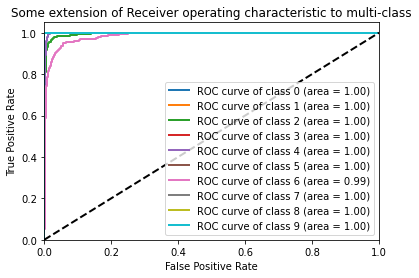

In [23]:
from sklearn.metrics import roc_curve, auc

# Plot all ROC curves
plt.figure()
lw = 2
y_score = clf.decision_function(X_train)

#colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
#for i, color in zip(range(n_classes), colors):
for i in range(10):
    fpr, tpr, _ = roc_curve(y_train, y_score[:,i], pos_label=i)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, lw=2,
             label=f'ROC curve of class {i} (area = {roc_auc:0.2f})')
             

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()


### Preguntes
1. Mostra les matrius de confusió del apartat A. En tindrem 1 per cada classificador que hagis provat: (SVC-binary, LinearSVC-binary, SVC-multiclass, LinearSVC-multiclass) 
2. Compara la curva ROC pels casos binaris de SVC i LinearSVC sobre la mateixa gràfica.
3. Compara la curva PR pels casos binaris de SVC i LinearSVC sobre la mateixa gràfica.
4. Compara les curves ROC del SVC multicategoria en una mateixa gràfica.
5. Compara les curves ROC dels classificadors per fer la tria final

### però aquest cop, la matriu de confusió cal extreure-la del conjunt de test.



#### Pregunta 1: Mostra les matrius de confusió del apartat A. En tindrem 1 per cada classificador que hagis provat: (SVC-binary, LinearSVC-binary, SVC-multiclass, LinearSVC-multiclass)

Just en la cel·la que tenim a sobre he importat HTML per modificar una mica el layout del nostre jupyter perquè els plots quedin centrats perquè quedi millor. No ho demanava l'exercici però penso que li dona més estètica al meu treball. No executar aquesta cel·la no canvia per a res els nostres resultats. És un retoc estètic.

In [1]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

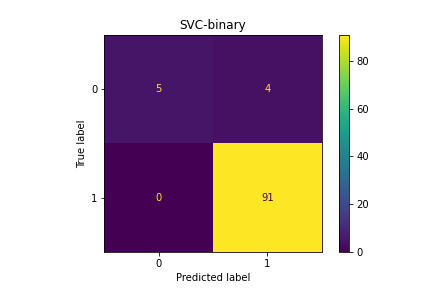

In [83]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay 

matconf_svcbin = confusion_matrix(y_smallb_test, llista_prediccions_binari[0])
matriu_1 = ConfusionMatrixDisplay(matconf_svcbin)
matriu_1.plot()
plt.title("SVC-binary")
plt.show()

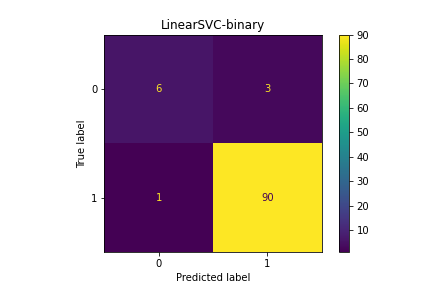

In [86]:
matconf_svcbin = confusion_matrix(y_smallb_test, llista_prediccions_binari[1])
matriu_2 = ConfusionMatrixDisplay(matconf_svcbin)
matriu_2.plot()
plt.title("LinearSVC-binary")
plt.show()

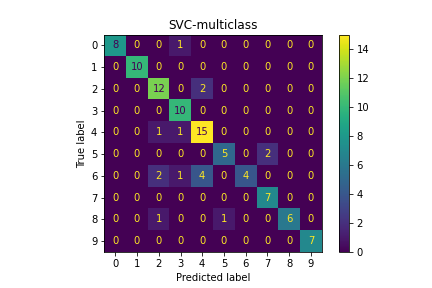

In [87]:
matconf_svcbin = confusion_matrix(y_small_test, llista_prediccions_multiclass[0])
matriu_3 = ConfusionMatrixDisplay(matconf_svcbin)
matriu_3.plot()
plt.title("SVC-multiclass")
plt.show()

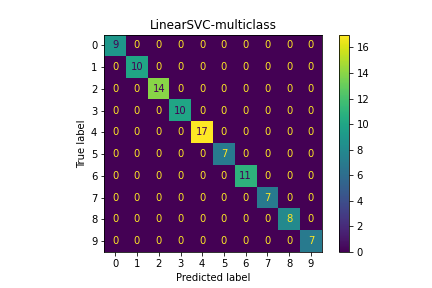

In [88]:
matconf_svcbin = confusion_matrix(y_small_test, llista_prediccions_multiclass[1])
matriu_4 = ConfusionMatrixDisplay(matconf_svcbin)
matriu_4.plot()
plt.title("LinearSVC-multiclass")
plt.show()

#### Pregunta 2: Compara la curva ROC pels cassos binaris de SVC i LinearSVC sobre la mateixa gràfica.

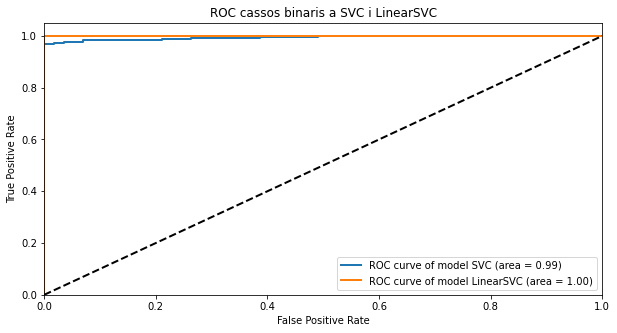

In [35]:
r = plt.figure(figsize=(10,5))
for j,z in zip([y_score_binary_svc, y_score_binary_lsvc],["SVC","LinearSVC"]):

    fpr, tpr, _ = roc_curve(y_smallb_train, j)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, lw=2,
    label=f'ROC curve of model {z} (area = {roc_auc:0.2f})')


plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC cassos binaris a SVC i LinearSVC')
plt.legend(loc="lower right")
plt.show()


#### Pregunta 3: Compara la curva PR pels casos binaris de SVC i LinearSVC sobre la mateixa gràfica.

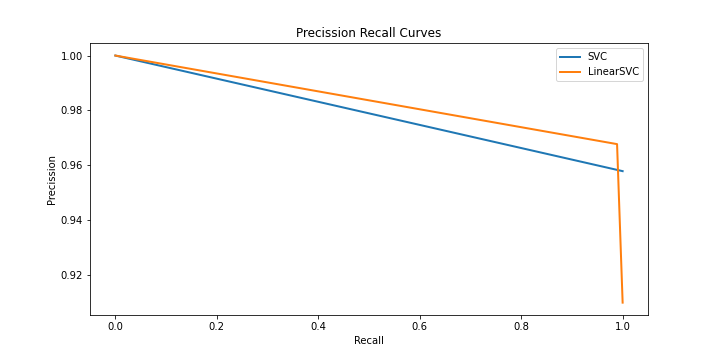

In [93]:
from sklearn.metrics import precision_recall_curve 

t = plt.figure(figsize=(10,5))
my_labels=["SVC", "LinearSVC"]
for i in range(2):
    precision, recall, _ = precision_recall_curve(y_smallb_test, llista_prediccions_binari[i])
    plt.plot(recall, precision, lw=2, label=my_labels[i])


plt.title("Precission Recall Curves")
plt.legend()
plt.xlabel("Recall")
plt.ylabel("Precission")
plt.show()

#### Pregunta 4: Compara les curves ROC del SVC multicategoria en una mateixa gràfica.

Primer mirarem les curves ROC amb un SVC multicategoria que és el que ens demana l'exercici: 

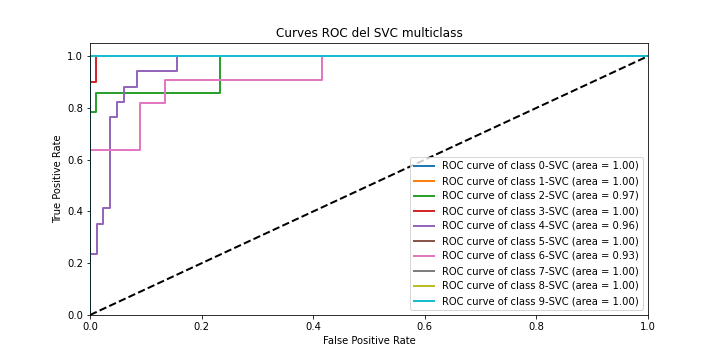

In [95]:
p = plt.figure(figsize=(10,5))
for j,z in zip([y_score_multiclass_svc],["SVC"]):
    for i in range(10):
        fpr, tpr, _ = roc_curve(y_small_train, j[:,i], pos_label=i)
        roc_auc = auc(fpr, tpr)

        plt.plot(fpr, tpr, lw=2,
                 label=f'ROC curve of class {i}-{z} (area = {roc_auc:0.2f})')


plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curves ROC del SVC multiclass')
plt.legend(loc="lower right")
plt.show()


Ara mirarem el que ens surt amb el LinearSVC que, tot i que sembla que no ens ho demani el professor em sembla interessant veure la gràfica que surt:

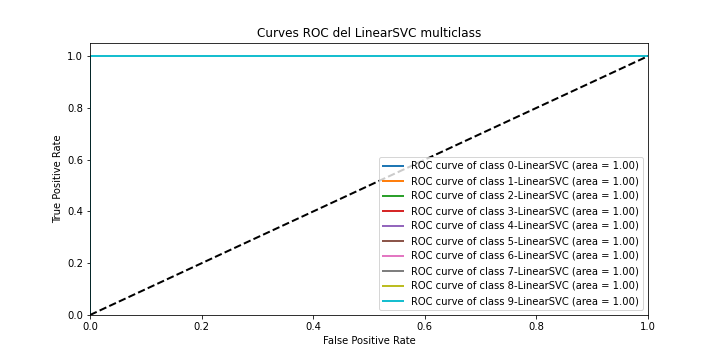

In [96]:
e = plt.figure(figsize=(10,5))
for j,z in zip([y_score_multiclass_lsvc],["LinearSVC"]):
    for i in range(10):
        fpr, tpr, _ = roc_curve(y_small_train, j[:,i], pos_label=i)
        roc_auc = auc(fpr, tpr)

        plt.plot(fpr, tpr, lw=2,
                 label=f'ROC curve of class {i}-{z} (area = {roc_auc:0.2f})')


plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curves ROC del LinearSVC multiclass')
plt.legend(loc="lower right")
plt.show()

#### Pregunta 5: Compara les curves ROC dels classificadors per fer la tria final.

Tot seguit mostrem les curves ROC pel classificador multicategoria KNN que hem provat.

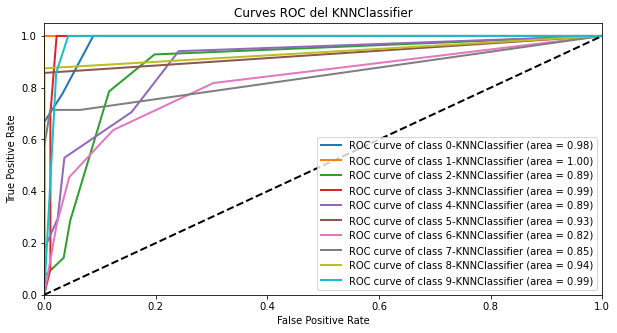

In [33]:
c = plt.figure(figsize=(10,5))
for i in ["KNNClassifier"]:
    for j in range(10):
        fpr, tpr, _ = roc_curve(y_small_test, y_scores_multiclass_knn[:, j], pos_label=j )
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2,
                     label=f'ROC curve of class {j}-{i} (area = {roc_auc:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curves ROC del KNNClassifier')
plt.legend(loc="lower right")
plt.show()

Ara mirarem les curves ROC amb el classificador en Lineal Regression fent servir un descens estocàstic del gradient (SGD).

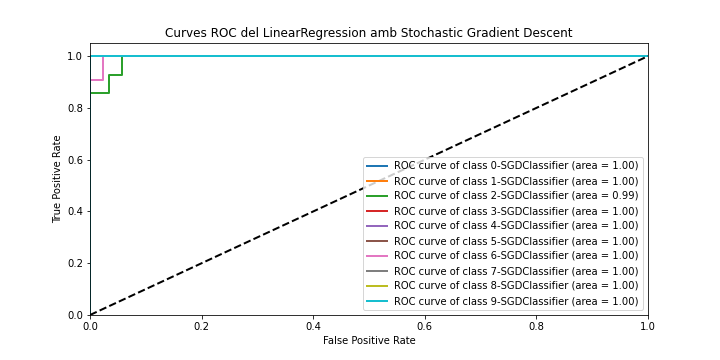

In [124]:
b = plt.figure(figsize=(10,5))
for j,z in zip([y_score_multiclass_sgdc],["SGDClassifier"]):
    for i in range(10):
        fpr, tpr, _ = roc_curve(y_small_train, j[:,i], pos_label=i)
        roc_auc = auc(fpr, tpr)

        plt.plot(fpr, tpr, lw=2,
                 label=f'ROC curve of class {i}-{z} (area = {roc_auc:0.2f})')


plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curves ROC del LinearRegression amb Stochastic Gradient Descent')
plt.legend(loc="lower right")
plt.show()

## C. Crossvalidation (30%)

Com debeu haver comprobat, els resultats quan s'usen les propies dades d'entrenament son molt alts. És quan apliqeum sobre dades noves qeu tenim resultats significatius. Però aquestes dades tampoc ens serveixen per triar els paràmetres del model.

Per aquest motiu, el que intentarem de fer en aquest apartat és gestionar les dades que tenim d'entrenament per a que poguem llavors trobar els millors hiperparametres que ens permetin aconseguir la millor taxa d'encert en dades mai vistes abans (per aquest motiu, no volem veure com és el test, ja que no volem fer trampes i optimitzar el nostre model sobre la sortida).

Ens basarem amb les eines de [cross-validació](https://scikit-learn.org/stable/modules/cross_validation.html).

<img src="https://scikit-learn.org/stable/_images/grid_search_cross_validation.png" width="500px">

Ara bé, tingueu també en compte, que tan important com utilitzar dades mai vistes per optimitzar el classificador, també s'ha de fer el mateix en l'apartat del preprocessat (com per exemple al normalitzar o estandaritzar les dades). No es poden aprendre les transformacions amb dades de "test".

El cas més senzill (menys linies de codi) es fer servir la funció [cross_validate](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html) i [make_pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.make_pipeline.html)

Ara bé, també cal que entengueu què s'hi fa dins, aixi que farem els dos casos

Exemple:

In [130]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import recall_score
scoring = ['accuracy','precision_macro', 'recall_macro']
#clf = SVC(kernel='linear', C=1, random_state=0)
clf = LinearSVC(C=1, random_state=0, max_iter=10000)
scores = cross_validate(clf, X_train, y_train, scoring=scoring, cv=5, return_train_score=True)
print(scores['test_accuracy'])


C:\Users\usuario\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\usuario\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\usuario\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\usuario\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[0.75166667 0.74333333 0.73833333 0.73666667 0.74      ]


C:\Users\usuario\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


### Preguntes
1. Utilitza la funció **cross_validate** i **make_pipepline** per trobar quin **accuracy** té el model **SVC()** amb les dades normalitzades amb **StandardScaler**. [(pista)](https://scikit-learn.org/stable/modules/cross_validation.html#the-cross-validate-function-and-multiple-metric-evaluation)
2. Analitza el diccionari de camps que t'ha retornat.
3. Implementa la funció per cross-validar un model i uns parametres en concret. Utilitza la següent funció **entrena_crossvalida** com a base.
4. Compara els resultats de la pregunta C.3 amb el de la pregunta C.1.


#### Pregunta 1: Utilitza la funció cross_validate i make_pipeline per trobar quin accuracy té el model SVC() amb les dades normalitzades amb StandardScaler.

In [132]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.pipeline import make_pipeline

pipeline = make_pipeline(StandardScaler(), SVC())
dic_scores = cross_validate(pipeline, x_smallb_train, y_smallb_train, scoring="accuracy", cv=5, return_train_score=True)
print("El model té un accuracy promig al test de: "+str(round(dic_scores["test_score"].mean(),3)))
print("El model té un accuracy promig al train de: "+str(round(dic_scores["train_score"].mean(),3)))

El model té un accuracy promig al test de: 0.957
El model té un accuracy promig al train de: 0.976


#### Pregunta 2: Analitza el diccionari que t'ha retornat.

Per veure el diccionari millor el que farem serà passar-lo a DataFrame i el podrem veure en format taula.
Al cridar la funció cross_validate que he fet servir al apartat anterior li passem el pipeline i els conjunts X i y (target) perquè pugui fer el crossvalidate i tot seguit li especifiquem la mètrica que volem treure que en aquest cas és el accuracy. També fixem el paràmetre cv a 5 que és el nombre de particions en les que volem fer el cross-validation, és a dir, els folds que hem vist a la figura que tenim al principi d'aquest apartat i el que hem estat veient a la sessió de pràctiques i finalment el que li passem és que ens retorni també els scores del train per tenir una mica més d'informació sobre el model.
El que veiem a la taula (diccionari que ens ha retornat la funció) són doncs els accuracy pels paràmetres del test i train així com el temps de fit i el seu score per cadascuna de les proves que li hem dit que faci, que en total són 5. Hem fet 5 particions diferents diguéssim del nostre training sel·leccionant part d'aquest com a test (un cinqué diferent per cadascuna de les proves que s'han fet), aleshores els valors que hem anat obtenint en les diferents particions per aquests atributs que hem dit és el que reflexa cada fila de la taula que mostrem tot seguit:

In [134]:
pd.DataFrame.from_dict(dic_scores)

,fit_time,score_time,test_score,train_score
0,0.024,0.008,0.967,0.975
1,0.022,0.008,0.967,0.977
2,0.023,0.008,0.958,0.973
3,0.022,0.007,0.933,0.985
4,0.021,0.007,0.958,0.969


#### Pregunta 3: Implementa la funció per cross-validar un model i uns paràmetres en concret. Utilitza l'esquelet donat (entrena_crossvalida).
Començem per inicialitzar el objecte Fold. Aquí li he passat el shuffle com a True perquè no perdem res al barrejar les dades i fins i tot ens pot aportar un advantatge perquè en cas que hi hagués alguna relació entre observacions (que en aquest cas no ho sembla perquè veiem un ordre bastant aleatori dels labels) podriem cometre l'error d'agafar una part del training per exemple amb la meitat dels labels perquè aquests estiguessin ordenats. Aleshores no perdem res en assegurar-nos i fer un shuffle del test perquè en principi no hauria d'haver-hi cap canvi al fer-ho. 

In [135]:
from sklearn.model_selection import KFold
import time
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score, f1_score, average_precision_score


def entrena_crossvalida(model, X, y, k_folds): 
    '''
    inputs:
       - model: el objecte que s'entrenarà
       - sample_size: el número de mostres del training set que es farán servir (en %)
       - X: caracteristiques entrenament
       - y: etiqueta entrenament
       - k_folds: número de folds d'entrenament
    '''
    results = {"elapsed": [], "train_accuracy": [], "train_f1_score": [], "train_ap": [], "val_accuracy": [],
              "val_f1_score": [], "val_ap": [], "accuracy_mean": [], "accuracy_std": []}
    #results = {"accuracy": [], "f1_score": [], "elapsed": []}

    """
    Inicialitza el FOLD objecte (i.e. KFold) amb k_folds. Cal fer shuffle a les dades?
    """
    kf = KFold(n_splits=k_folds, shuffle=True)
    
    """
    Itera les dades per cada fold:
    """
    mean=[]
    std=[]
    for i, (train_index, val_index) in tqdm(enumerate(kf.split(X))):
        t_i = time.time()
        print("CROSSVALIDANT FOLD {}".format(i+1))
        X_train, X_val = X.loc[X.index.intersection(train_index), :], X.loc[X.index.intersection(val_index), :]
        y_train, y_val = y[y.index.intersection(train_index)], y[y.index.intersection(val_index)]
 
        """
        Entrena el model amb X_train i y_train:
        """
        model.fit(X_train, y_train)
        
        """
        Obtenir les prediccions del model sobre el conjunt d'entrenament i sobre el conjunt de test
        """
        pred_train = model.predict(X_train)
        pred_val = model.predict(X_val)
        score_train = model.decision_function(X_train)
        score_val = model.decision_function(X_val)
        
        """
        Calcular el accuracy i el F1-score del train i del test
        """
        
        train_accuracy = accuracy_score(y_train, pred_train)
        train_f1_score = f1_score(y_train, pred_train)
        train_ap = average_precision_score(y_train, pred_train)
        val_accuracy = accuracy_score(y_val, pred_val)
        val_f1_score = f1_score(y_val, pred_val)
        val_ap = average_precision_score(y_val, pred_val)
        
        mean.append(round((train_accuracy+val_accuracy)/2, 3))
        std.append(np.std([train_accuracy, val_accuracy]))

        results["train_accuracy"].append(train_accuracy)
        results["train_f1_score"].append(train_f1_score)
        results["train_ap"].append(train_ap)
        results["val_accuracy"].append(val_accuracy)
        results["val_f1_score"].append(val_f1_score)
        results["val_ap"].append(val_ap)
        results["elapsed"].append(time.time() - t_i)
        
    
    #results["accuracy_mean"] = np.mean(results["val_accuracy"])
    #results["accuracy_std"] = np.std(results["val_accuracy"])
    
    results["accuracy_mean"] = mean
    results["accuracy_std"] = std

    #results["accuracy_mean"] = np.mean(results["accuracy"])
    #results["accuracy_std"] = np.std(results["accuracy"])
    
    
    
    print("\nEl model {} té un accuracy promig en {} folds de {} +- {}.".format(model.__class__.__name__, 
                                                                                 k_folds,
                                                                                 np.mean(results["accuracy_mean"]),
                                                                                 np.mean(results["accuracy_std"])))
    
    
    return results
 

In [136]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

model = SVC()
resultats = entrena_crossvalida(model, x_smallb_train, y_smallb_train, k_folds=5)
print("\n---------------------\n"+str(pd.DataFrame.from_dict(resultats).to_string()))


0it [00:00, ?it/s]

CROSSVALIDANT FOLD 1
CROSSVALIDANT FOLD 2
CROSSVALIDANT FOLD 3
CROSSVALIDANT FOLD 4
CROSSVALIDANT FOLD 5

El model SVC té un accuracy promig en 5 folds de 0.9588000000000001 +- 0.012083333333333335.

---------------------
   elapsed  train_accuracy  train_f1_score  train_ap  val_accuracy  val_f1_score  val_ap  accuracy_mean  accuracy_std
0    0.078           0.967           0.982     0.974         0.942         0.968   0.938          0.954         0.013
1    0.060           0.973           0.985     0.979         0.917         0.953   0.942          0.945         0.028
2    0.066           0.967           0.981     0.974         0.967         0.982   0.982          0.967         0.000
3    0.067           0.975           0.986     0.981         0.950         0.973   0.963          0.962         0.013
4    0.066           0.973           0.985     0.981         0.958         0.977   0.963          0.966         0.007


#### Pregunta 4: Compara els resultats del apartat C.3 amb els del C.1
Als dos cassos he fet servir el dataset binari (amb dues labels només en comptes de la multiclass) perquè al fer servir la multiclass en la funció que se'ns demanava no podia calcular algunes mètriques com el AP (Average Precission) per ser multilabel i altres mètriques em demanaven de canviar alguns paràmetres dels que el professor no ens ha parlat mai tampoc així que vaig pensar en fer-ho amb el binari perquè semblava ser el més adient amb el que haviem parlat a la classe de pràctiques. 
Així i tot els valors del accuracy promig tant al test com pel train així com per tots dos és bastant proper al que ens surt amb la funció del cross-validate que hem implementat just a sobre. Els valors de la funció importada de sklearn.model_selection segueixen sent més alts que els que ens surten a la funció que hem fet perquè segurament la funció de llibreria estarà molt més optimitzada i serà més precissa pel que fa a les operacions i metodologia que s'apliquen sobre les dades que la nostra pròpia, però tot i així ens apropem bastant.

## D. Hyperparameter search (20%)

Finalment, crossvalidar un model serveix per tenir una idea bastant aproximada del performance que hauriem d'aconseguir amb un model, unes dades i uns hiperparametres concrets sobre unes dades mai vistes abans. Llavors, si tenim unes dades d'entrenament donades, el que hem d'optimitzar és buscar quin model i quins hiperparametres s'ajusten millor a les nostres necesitats (i.e. més precisió, la millor precisió tenint el compte el cost...).

Per fer això, existeix la búsqueda de hiperparametres. En el cas de SVM, per exemple, podriem optimitzar la C (la força de la regularització), el kernel a utilitzar, els parametres propis de cada kernel (degree  pel 'poly', gamma per ‘rbf’, ‘poly’ i ‘sigmoid’...).

Un exemple de búsqueda de hiperparametres es el [GridSearch](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html). Aqui, es faran les N combinacions segons els parametres i els valors especificats.

Una altra opció és utilitzar una búsqueda Aleatoria del valors, i esperar a trobar la millor solució. D'això se'n diu [RandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html). En aquest cas, pots definir el **n_iter** que vols que provi. Es a dir, si dius que n_iter=10, farà 10 proves amb diferents valors dels hiperparametres.

Exemple:

In [3]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import uniform, loguniform
from sklearn.svm import LinearSVC, SVC
import time 

#model = SVC()
#distributions = dict(C=uniform(loc=0.001, scale=10),
#                     kernel=['poly', 'rbf'],
#                     gamma=uniform(loc=0.001, scale=10))
#clf = RandomizedSearchCV(model, distributions, random_state=0, n_iter=10)

model = LinearSVC(max_iter=10000)
distributions = dict(C=[0.00000001, 0.0000001, 0.000001])
#distributions = dict(C=[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000])
clf = GridSearchCV(model, distributions, refit=True)


#model = LinearSVC(max_iter=10000)
#distributions = dict(C=uniform(loc=0.001, scale=10))
#clf = RandomizedSearchCV(model, distributions, random_state=0, n_iter=10)


search = clf.fit(X_train, y_train)
print("BEST PARAMS: {}".format(search.best_params_))
print("BEST SCORE: {}".format(search.best_score_))

BEST PARAMS: {'C': 1e-06}
BEST SCORE: 0.835


In [7]:
clf.cv_results_

{'mean_fit_time': array([0.28286505, 0.50621476, 2.26499019]),
 'std_fit_time': array([0.0135584 , 0.01775312, 0.14947325]),
 'mean_score_time': array([0.01140981, 0.00640044, 0.00620155]),
 'std_score_time': array([0.01034496, 0.00048903, 0.00039969]),
 'param_C': masked_array(data=[1e-08, 1e-07, 1e-06],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 1e-08}, {'C': 1e-07}, {'C': 1e-06}],
 'split0_test_score': array([0.79666667, 0.83666667, 0.8325    ]),
 'split1_test_score': array([0.78083333, 0.82666667, 0.835     ]),
 'split2_test_score': array([0.78083333, 0.835     , 0.83666667]),
 'split3_test_score': array([0.805 , 0.8375, 0.835 ]),
 'split4_test_score': array([0.795     , 0.83083333, 0.83583333]),
 'mean_test_score': array([0.79166667, 0.83333333, 0.835     ]),
 'std_test_score': array([0.00947218, 0.00404832, 0.00139443]),
 'rank_test_score': array([3, 2, 1])}

### Preguntes
1. Fes una estimació (sense implementar-ho) del número de crosvalidacions que hauries de provar pels diferents parametres i les seves combinacions. Per exemple, considerant només el kernel 'rbf'. Quins hiperparametres poden afectar al resultat final, i quins valors per cada parametre provaries. Conta la seva combinació i multiplicau pel temps que triga a fer una sola crossvalidació.

2. Utilitza **GridSearch** per fer la búsqueda de parametres. Tingues en compte els tipus parametres i les quantitats de valors a provar. Quins hi posaries si no vols que trigui més de 30 minuts.

3. Utilitza **RandomizedSearchCV** per fer búscar els parametres. No permetis que trigui més de 30 minuts. Quins valors ha provat?

4. Quin dels dos mètodes ha donat millor resultat, tenint en compte les restriccions de temps de 30 minuts de cerca.

5. Ara si, evalua el millor model sobre el conjunt de test **'fashion-mnist_test_small.csv'**.

6. Finalment, amb el millor model que hagis aconseguit sobre 'fashion-mnist_train_small.csv', fes un test sobre 'fashion-mnist_test.csv'. Quin resultat obtens? Son similars als de D.5??


#### Pregunta 1: Fes una estimació (sense implementar res) del nombre de crossvalidacions que hauries de provar pels diferents parametres i les seves combinacions. Per exemple, considerant només el kernel "rbf". Quins hiperparametres poden afectar el resultat final, i quins valors per cada parametre provaries?. Conta la seva combinació i multiplica-ho pel temps que triga en fer una sola crossvalidació.

Aquí realment els dos paràmetres que més afecten al kernel "rbf" (que és amb el que ens demana la pràctica que treballem)
són els paràmetres gamma i c. Aleshores jo en el meu cas agafaré 2 valors per gamma i 3 per c. En el cas del GridSearch per exemple es farien 6 combinacions de paràmetres. Nosaltres treballariem amb un 5-fold validation per exemple així que entrenariem el nostre model 5x6 = 30 cops. Si de mitjana fiquem que ens triga 8 segons per entrenament aixo suposarà 30*8/60 = 4 minuts (240 segons aprox.)
Tot seguit fem una prova i veiem que els resultats són bastant propers a les nostres prediccions, tot i que sempre varia una mica depenent de l'execució. 
També podriem pensar en la casuística en la que aprofitem la prestació que tant el GridSearch com el RandomizedSearch ens ofereix pel que fa al multithreading. Si passem el paràmetre n_jobs podrem especificar els fils amb els que volem que treballi, si fiquem per exemple n_jobs=-1 els agafarà tots aquells que estiguin disponibles atenint les especificacions del nostre hardware i per tant amb paral·lelització l'execució serà encara més ràpida. 

In [73]:
import time 
t_0 = time.time()
clf = GridSearchCV(SVC(), {
    'C': [0.000001, 0.001, 0.1],
    'gamma': [0.000001, 0.001],
    'kernel': ['rbf']}, cv=5, return_train_score=False, verbose=2)
clf.fit(X_train, y_train)
t_1 = time.time() - t_0
print("El procés del GridSearch pels paràmetres escollits ha trigat: "+str(t_1)+" segons.")


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] END ...................C=1e-06, gamma=1e-06, kernel=rbf; total time=   7.6s
[CV] END ...................C=1e-06, gamma=1e-06, kernel=rbf; total time=   7.5s
[CV] END ...................C=1e-06, gamma=1e-06, kernel=rbf; total time=   7.5s
[CV] END ...................C=1e-06, gamma=1e-06, kernel=rbf; total time=   7.5s
[CV] END ...................C=1e-06, gamma=1e-06, kernel=rbf; total time=   7.5s
[CV] END ...................C=1e-06, gamma=0.001, kernel=rbf; total time=   9.1s
[CV] END ...................C=1e-06, gamma=0.001, kernel=rbf; total time=   9.4s
[CV] END ...................C=1e-06, gamma=0.001, kernel=rbf; total time=   9.2s
[CV] END ...................C=1e-06, gamma=0.001, kernel=rbf; total time=   9.1s
[CV] END ...................C=1e-06, gamma=0.001, kernel=rbf; total time=   9.2s
[CV] END ...................C=0.001, gamma=1e-06, kernel=rbf; total time=   7.7s
[CV] END ...................C=0.001, gamma=1e-06,

#### Pregunta 2: Utilitza GridSearch per fer la búsqueda de parametres. Tingues en compte els tipus de parametres i les quantitats de valors a provar. Quins hi posaries si no vols que trigui més de 30 minuts?

In [18]:
import time 
t_0 = time.time()
clf = GridSearchCV(SVC(), {
    'C': [0.000001, 0.001, 0.1],
    'gamma': [0.000001, 0.001, 0.1],
    'kernel': ['rbf']}, cv=5, return_train_score=False, verbose=2, n_jobs=-1)
clf.fit(X_train, y_train)
t_1 = time.time() - t_0
print("El procés del GridSearch pels paràmetres escollits ha trigat: "+str(t_1)+" segons.")


Fitting 5 folds for each of 9 candidates, totalling 45 fits
El procés del GridSearch pels paràmetres escollits ha trigat: 292.2365984916687 segons.


In [19]:
df_gs = pd.DataFrame(clf.cv_results_)
df_gs

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,71.507,0.637,9.999,0.134,0.000,0.000,rbf,"{'C': 1e-06, 'gamma': 1e-06, 'kernel': 'rbf'}",0.105,0.105,0.105,0.105,0.105,0.105,0.000,2
1,72.955,0.362,10.273,0.193,0.000,0.001,rbf,"{'C': 1e-06, 'gamma': 0.001, 'kernel': 'rbf'}",0.105,0.105,0.105,0.105,0.105,0.105,0.000,2
2,72.380,0.734,9.918,0.197,0.000,0.100,rbf,"{'C': 1e-06, 'gamma': 0.1, 'kernel': 'rbf'}",0.105,0.105,0.105,0.105,0.105,0.105,0.000,2
3,70.784,0.975,9.512,0.134,0.001,0.000,rbf,"{'C': 0.001, 'gamma': 1e-06, 'kernel': 'rbf'}",0.105,0.105,0.105,0.105,0.105,0.105,0.000,2
4,73.451,0.845,10.076,0.433,0.001,0.001,rbf,"{'C': 0.001, 'gamma': 0.001, 'kernel': 'rbf'}",0.105,0.105,0.105,0.105,0.105,0.105,0.000,2
5,72.811,2.921,9.854,0.423,0.001,0.100,rbf,"{'C': 0.001, 'gamma': 0.1, 'kernel': 'rbf'}",0.105,0.105,0.105,0.105,0.105,0.105,0.000,2
6,54.712,1.496,8.745,0.234,0.100,0.000,rbf,"{'C': 0.1, 'gamma': 1e-06, 'kernel': 'rbf'}",0.685,0.654,0.663,0.682,0.702,0.677,0.017,1
7,52.620,11.637,6.018,1.180,0.100,0.001,rbf,"{'C': 0.1, 'gamma': 0.001, 'kernel': 'rbf'}",0.105,0.105,0.105,0.105,0.105,0.105,0.000,2
8,37.041,3.188,3.624,0.752,0.100,0.100,rbf,"{'C': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}",0.105,0.105,0.105,0.105,0.105,0.105,0.000,2


In [20]:
df_gs[["param_C", "param_gamma", "mean_test_score"]]

,param_C,param_gamma,mean_test_score
0,0.000,0.000,0.105
1,0.000,0.001,0.105
2,0.000,0.100,0.105
3,0.001,0.000,0.105
4,0.001,0.001,0.105
5,0.001,0.100,0.105
6,0.100,0.000,0.677
7,0.100,0.001,0.105
8,0.100,0.100,0.105


Veiem al dataframe que hem creat que arribem a tenir un test_score de 0.677 quan la C és més gran (cap al 1) i la gamma més petita (cap al 0). Tornarem a fer una prova ficant ara valors per C entre 0.1 i 1 i la gamma la provarem a 1e-6 i 1e-7. També provaré el multithreading per veure el speed-up que això ens aporta. 

In [15]:
t_0 = time.time()
clf = GridSearchCV(SVC(), {
    'C': [0.1, 0.35, 0.6],
    'gamma': [0.000001, 0.0000001],
    'kernel': ['rbf']}, cv=5, return_train_score=False, verbose=2, n_jobs=-1)
clf.fit(X_train, y_train)
t_1 = time.time() - t_0
print("El procés del GridSearch pels paràmetres escollits ha trigat: "+str(t_1)+" segons.")


Fitting 5 folds for each of 6 candidates, totalling 30 fits
El procés del GridSearch pels paràmetres escollits ha trigat: 94.70224237442017 segons.


In [16]:
pd.DataFrame(clf.cv_results_)[["param_C", "param_gamma", "mean_test_score"]]

,param_C,param_gamma,mean_test_score
0,0.100,0.000,0.677
1,0.100,0.000,0.775
2,0.350,0.000,0.783
3,0.350,0.000,0.814
4,0.600,0.000,0.814
5,0.600,0.000,0.827


Ara veiem que el test_score ja ens puja bastant més si comparem aquests valors amb els que hem obtingut abans. Pel que fa als advantatges del multithreading ens ha suposat un speed-up de 2,5x.

#### Pregunta 3: Utilitza RandomizedSearchCV per buscar els paràmetres. No permetis que trigui més de 30 minuts. Quins has provat?

In [45]:
t_0 = time.time()
rs = RandomizedSearchCV(SVC(), {
    'C': [0.95,0.96, 0.965, 0.975, 0.985, 0.9, 0.95, 1,7.5,15,22.5],
    'gamma': [0.000001, 0.0000001],
    'kernel': ['rbf', 'poly', 'sigmoid']}, cv=5, return_train_score=False, n_iter=15, verbose=3, n_jobs=-1)
rs.fit(X_train, y_train)
t_1 = time.time() - t_0
print("El procés del RandomizedSearch pels paràmetres escollits ha trigat: "+str(t_1)+" segons.")

Fitting 5 folds for each of 15 candidates, totalling 75 fits
El procés del RandomizedSearch pels paràmetres escollits ha trigat: 173.46520709991455 segons.


In [46]:
pd.DataFrame(rs.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_kernel,param_gamma,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,13.741,0.215,5.098,0.407,rbf,0.000,1,"{'kernel': 'rbf', 'gamma': 1e-07, 'C': 1}",0.847,0.822,0.838,0.846,0.836,0.838,0.009,2
1,58.300,2.421,8.347,0.370,sigmoid,0.000,0.975,"{'kernel': 'sigmoid', 'gamma': 1e-06, 'C': 0.975}",0.160,0.163,0.144,0.151,0.159,0.156,0.007,15
2,18.382,0.613,4.323,0.206,poly,0.000,0.950,"{'kernel': 'poly', 'gamma': 1e-07, 'C': 0.95}",0.771,0.751,0.770,0.779,0.757,0.766,0.010,12
3,8.664,0.488,2.617,0.086,poly,0.000,15,"{'kernel': 'poly', 'gamma': 1e-06, 'C': 15}",0.840,0.827,0.813,0.828,0.832,0.828,0.009,11
4,18.628,0.502,4.665,0.402,poly,0.000,0.960,"{'kernel': 'poly', 'gamma': 1e-07, 'C': 0.96}",0.772,0.752,0.769,0.778,0.757,0.766,0.010,12
5,12.401,0.696,4.906,0.088,rbf,0.000,15,"{'kernel': 'rbf', 'gamma': 1e-07, 'C': 15}",0.862,0.862,0.859,0.868,0.854,0.861,0.004,1
6,8.924,0.347,2.678,0.125,poly,0.000,0.960,"{'kernel': 'poly', 'gamma': 1e-06, 'C': 0.96}",0.843,0.828,0.815,0.840,0.832,0.831,0.010,10
7,46.744,2.394,7.978,0.543,rbf,0.000,0.950,"{'kernel': 'rbf', 'gamma': 1e-06, 'C': 0.95}",0.844,0.823,0.831,0.841,0.823,0.832,0.009,7
8,13.638,0.199,5.641,0.465,rbf,0.000,0.975,"{'kernel': 'rbf', 'gamma': 1e-07, 'C': 0.975}",0.847,0.821,0.836,0.845,0.835,0.837,0.009,3
9,45.989,2.168,7.985,0.907,rbf,0.000,0.960,"{'kernel': 'rbf', 'gamma': 1e-06, 'C': 0.96}",0.846,0.823,0.830,0.840,0.823,0.832,0.009,6


In [47]:
pd.DataFrame(rs.cv_results_)[["param_kernel","param_C", "param_gamma", "mean_test_score"]]

,param_kernel,param_C,param_gamma,mean_test_score
0,rbf,1,0.000,0.838
1,sigmoid,0.975,0.000,0.156
2,poly,0.950,0.000,0.766
3,poly,15,0.000,0.828
4,poly,0.960,0.000,0.766
5,rbf,15,0.000,0.861
6,poly,0.960,0.000,0.831
7,rbf,0.950,0.000,0.832
8,rbf,0.975,0.000,0.837
9,rbf,0.960,0.000,0.832


In [48]:
print("Els millors paràmetres han estat: ",rs.best_params_)
print("El millor score: ", rs.best_score_)

Els millors paràmetres han estat:  {'kernel': 'rbf', 'gamma': 1e-07, 'C': 15}
El millor score:  0.8608333333333335


Veiem doncs que la millor configuració de paràmetres la veiem amb el kernel rbf amb una gamma que es repeteix tres vegades pels tres valors alts que ens ha donat amb rbf. Ara per curiositat el que faré serà fer un GridSearch més específic fixant aquesta gamma per uns valors de C entre 15 i 30 per exemple. Amb C=15 ja veiem que ens ha pujat el rbf al RandomizedSearch...
Tot i que no ho mostro aquí executat he fet proves amb gamma 1e-5 i 1e-8 i en aquests dos cassos el test_score em donava bastant més petit que amb 1e-6 i 1e-7. Aleshores el rang d'una bona configuració seria gamma[1e-6, 1e-7] i C=23 per kernel='rbf'.

In [53]:
t_0 = time.time()
clf = GridSearchCV(SVC(), {
    'C': [15,23,24,25,26,30],
    'gamma': [1e-7],
    'kernel': ['rbf']}, cv=5, return_train_score=False, verbose=2, n_jobs=-1)
clf.fit(X_train, y_train)
t_1 = time.time() - t_0
print("El procés del GridSearch pels paràmetres escollits ha trigat: "+str(t_1)+" segons.")


Fitting 5 folds for each of 6 candidates, totalling 30 fits
El procés del GridSearch pels paràmetres escollits ha trigat: 38.94027018547058 segons.


In [54]:
pd.DataFrame(clf.cv_results_)[["param_C", "param_gamma", "mean_test_score"]]

,param_C,param_gamma,mean_test_score
0,15,0.000,0.861
1,23,0.000,0.862
2,24,0.000,0.861
3,25,0.000,0.860
4,26,0.000,0.860
5,30,0.000,0.859


#### Pregunta 4: Quin dels dos mètodes ha donat un resultat millor tenint en compte els 30 minuts de límit?
Aquesta pregunta depèn bastant de la interpretació que es faci de les proves que hem fet. Hem fet servir tant RandomizedSearch com GridSearch i pel que jo he vist, cadascuna d'aquestes implementacions per trobar hiperparàmetres tenen un propòsit una mica diferent al altre. Al RandomizedSearch podem passar molts valors per provar diferents configuracions d'alguns paràmetres concrets fent servir un mateix o diferents kernels i aquesta funció agafarà aleatòriament n parelles de valors de forma aleatòria dels que s'han generat o s'han fixat a la llista per cadascún dels paràmetres i ens retornarà una informació bastant important però purament holística o generalista diguessim. Es pot donar el cas que de forma aleatòria s'agafin uns valors concrets que ens donin un test_score molt elevat però hem de tenir en compte que això serà doncs una component purament estocàstica que no sempre tindrem de la nostra part. Tindrem més variabilitat de configuracions.
Per una altra banda al GridSearch el que tindrem serà una informació molt més concreta ja que ens farà totes les combinacions possibles dels valors que haurem definit per cadascún dels paràmetres. Aleshores en una prova inicial més aleatòria amb un RandomizedSearch potser poguem donar amb uns valors que ens donin un test_score acceptable i tot seguit ens interessi fer servir un GridSearch per fer proves més exhaustives amb uns valors més concrets mirant com responen totes les combinacions possibles al nostre model amb un kernel determinat per exemple. Aquesta aproximació del GridSearch per aquest motiu em sembla menys holístic i més específic. 
Tot i aquestes diferències que jo crec és molt important tenir en ment per saber més o menys quina usabilitat podriem fer de cadascuna d'aquestes, si ens basem amb resultats doncs veurem que al GridSearch inicial arribem a uns valors de test_score molt baixos però veiem una configuració de valors per la qual puja bastant, aleshores si fem "zoom" en aquest rang de valors que sembla fer gran el test_score i tornem a fer un GridSearch amb uns valors entorn a aquests ja veiem configuracions més interessants. Veiem que amb C=0.6 i gamma=1e-6 per kernel tipus rbf arribem a un 0.827 de test_score.  
Per una altra banda al RandomizedSearch veiem dos configuracions amb poly fins i tot millor a la darrera rbf tot i que no gaire, i una rbf amb test_score més gran que el darrer també. Al RandomizedSearch per la seva component probabilística ens dona informació més general del conjunt de paràmetres amb els que tractem. 

#### Pregunta 5: Ara sí, evalua el millor model sobre el conjunt de test 'fashion-mnist_test_small.csv'

In [4]:
from sklearn.metrics import accuracy_score

dataset_prova_test = load_dataset("fashion-mnist_test_small.csv")
#dataset_prova_train = load_dataset("fashion-mnist_train_small.csv")
y_test = dataset_prova_test["label"]
X_test = dataset_prova_test.drop("label", axis="columns")
#y_train = dataset_prova_train["label"]
#X_train = dataset_prova_train.drop("label", axis="columns")
model_final = SVC(C=23, gamma=1e-7, kernel='rbf')
model_final.fit(X_train, y_train)
prediccio_test = model_final.predict(X_test)
prediccio_train = model_final.predict(X_train)
score_test = accuracy_score(y_test, prediccio_test)
score_train = accuracy_score(y_train, prediccio_train)
print("El millor model té un test accuracy de: "+str(round(score_test,3)))
print("El millor model té un train accuracy de: "+str(round(score_train,3)))


El millor model té un test accuracy de: 0.83
El millor model té un train accuracy de: 0.992


Quin problema tenim si fem servir C=23??...
Aquí veiem que hi ha una gran diferència entre el test i el train, tenim un error de variance, depenem molt de les dades de entrada i no hem generalitzat gens. Aquesta configuració no ens serveix de res perquè estem fent un overfitting al cap i a la fi, és a dir, l'únic que fem aquí és "simular" o modelar les dades, no generalitzem correctament el nostre problema, l'objectiu és que la diferència entre test i train sigui més petita i això ens dirà que estem generalitzant molt millor les dades del train i que no som tant dependents dels valors d'entrada.
Tot seguit el que farem serà fer servir una altra configuració amb una C molt més petita que també ens hagi donat un test_score elevat per veure com respòn tant al train com al test:

In [25]:
dataset_prova_test = load_dataset("fashion-mnist_test_small.csv")
#dataset_prova_train = load_dataset("fashion-mnist_train_small.csv")
y_test = dataset_prova_test["label"]
X_test = dataset_prova_test.drop("label", axis="columns")
#y_train = dataset_prova_train["label"]
#X_train = dataset_prova_train.drop("label", axis="columns")
model_final = SVC(C=0.95, gamma=1e-7, kernel='rbf')
model_final.fit(X_train, y_train)
prediccio_test = model_final.predict(X_test)
prediccio_train = model_final.predict(X_train)
score_test = accuracy_score(y_test, prediccio_test)
score_train = accuracy_score(y_train, prediccio_train)
print("El millor model té un test accuracy de: "+str(round(score_test,3)))
print("El millor model té un train accuracy de: "+str(round(score_train,3)))

El millor model té un test accuracy de: 0.87
El millor model té un train accuracy de: 0.872


Efectivament, quí ja veiem una altra cosa, aquí ja ens baixa el accuracy sobre el train, i tant test com train estàn bastant equilibrats, es redueix el error de variance i tenim un model que generalitza molt millor les dades. Abans ens haviem passat amb el paràmetre C, era massa gran i això feia que estiguéssim fent un overfitting que per a res ens interessa. Aquí ja veiem que el model és més consistent, el test_score ens importa però al cap i a la fi volem un model que tingui un error de variance reduït i que sigui capaç de generalitzar el problema amb el que estem treballant. 

#### Pregunta 6: Finalment, amb el millor model que hagis aconseguit sobre 'fashion-mnist_train_small.csv', fes un test sobre 'fashion-mnist_test.csv'. Quin resultat obtens? Son similars als de D.5??


In [26]:
dataset_prova_test = load_dataset("fashion-mnist_test.csv")
#dataset_prova_train = load_dataset("fashion-mnist_train.csv")
y_test = dataset_prova_test["label"]
X_test = dataset_prova_test.drop("label", axis="columns")
#y_train = dataset_prova_train["label"]
#X_train = dataset_prova_train.drop("label", axis="columns")
model_final = SVC(C=0.95, gamma=1e-7, kernel='rbf')
model_final.fit(X_train, y_train)
prediccio_test = model_final.predict(X_test)
prediccio_train = model_final.predict(X_train)
score_test = accuracy_score(y_test, prediccio_test)
score_train = accuracy_score(y_train, prediccio_train)
print("El millor model té un test accuracy de: "+str(round(score_test,3)))
print("El millor model té un train accuracy de: "+str(round(score_train,3)))


El millor model té un test accuracy de: 0.837
El millor model té un train accuracy de: 0.872


Aquí el resultat evidentment havia de ser més petit perquè ja estem fent test amb el dataset gran. Aleshores quan més dades tinguem el que passarà és que tindrem un marge d'error més alt i el accuracy doncs baixarà perquè tindrem molta variabilitat a les dades amb les que estem fent el test. Així i tot el resultat comparat amb el d'abans no es gens dolent al meu parer. 

## E. Extra (+10% màxim 10 pts a la practica)

El qui ho vulgui, pot realitzar un entrenament amb les dades completes (i.e. fashion-mnist_train.csv) i fer el test sobre fashion-mnist_test.csv.

Tingueu en compte que l'entrenament pot ser **molt costós** (varies hores sense fer crosvalidació amb el SVC). Us recomano de només fer servir **LinearSVC** (Podeu limitar el numero de max_iter..)

### Preguntes
1. Els millors parametres trobats en els apartats anteriors segueixent funcionant aqui?
2. Quin resultat has obtingut al tenir moltes més dades d'entrenament? 
3. Compareu els vostres resultats amb [l'estat de l'art obtinguts amb sklearn o deep learning](https://github.com/zalandoresearch/fashion-mnist#benchmark)





#### Pregunta 1: Els millors paràmetres trobats en els apartats anteriors segueixen funcionant aquí?

Diria que no perquè en aquest apartat treballem amb el LinearSVC aleshores els paràmetres canvien, de fet el LinearSVC només tindria un kernel si el comparem amb el SVC i seria el lineal. No hi ha cap paràmetre gamma ni res a part del paràmetre C que ens diu com de forta serà la regularització.


In [ ]:
dataset = load_dataset('fashion-mnist_test.csv')
dataset_prova_train = load_dataset("fashion-mnist_train.csv")
y_test = dataset["label"]
X_test = dataset.drop("label", axis="columns")
y_train = dataset_prova_train["label"]
X_train = dataset_prova_train.drop("label", axis="columns")
model_extra = LinearSVC(max_iter=10000)
model_extra.fit(X_train, y_train)
prediccio_test = model_extra.predict(X_test)
accuracy_test = accuracy_score(y_test, prediccio_test)
print("El accuracy sobre el test en aquest cas serà de: "+str(round(accuracy_test,3)))



In [ ]:
%%time
y_test_scr = clf.decision_function(X_test)

accuracy_test = accuracy_score(y_test, y_test_pred)

print("The accuracy on test is {}".format(accuracy_test))